# Graph  Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pickle
import subprocess
import sys
from dataclasses import dataclass
from pathlib import Path
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))
save_dir = Path(".").resolve() / "results"

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from matplotlib import rc

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.mlp import TransformerFeedForward
from models.normalization import RMSNorm
from visualization.graph import build_1L_graph, build_1L_graph_tokens

DEVICE = torch.device("cuda:0")
SEED = None
SEED = 1
if SEED:
    RNG = np.random.default_rng(SEED)
    np.random.seed(seed=SEED)
    torch.manual_seed(seed=SEED)

Data Generation

In [3]:
vocab_size = 2
vocab_size = 4
bsz = 2048
length = 8
sparsity_index = 5

# we create a modular addition problem on some subset of the input only
data = np.random.rand(bsz, length) // (1 / vocab_size)
targets = data[:, :sparsity_index].sum(axis=1) % vocab_size
# data = data.repeat(2, axis=1)

test_bsz = 128
test_data = np.random.rand(test_bsz, length) // (1 / vocab_size)
for i in range(vocab_size):
    test_data[i] = i
test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size
# test_data = test_data.repeat(2, axis=1)

# length = 24

In [4]:
print(f"Total number of unique sequences {vocab_size ** length}")

Total number of unique sequences 65536


In [5]:
from torch.utils.data import Dataset


class Dataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.from_numpy(data.astype(int)).to(torch.long)
        self.targets = torch.from_numpy(targets).to(torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

train_dataset = Dataset(data, targets)
test_dataset = Dataset(test_data, test_targets)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model

In [6]:
class SoftmaxLayer(nn.Module):
    def __init__(self, emb_dim):
        super(SoftmaxLayer, self).__init__()
        self.emb_dim = emb_dim
        self.query = nn.Linear(emb_dim, 1, bias=False)
        self.value = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, x, verbose=False):
        # x: [bsz, seq_len, emb_dim]
        query = self.query.weight
        key = x
        value = self.value(x)

        attn = query @ key.transpose(-1, -2) / math.sqrt(self.emb_dim)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ value).squeeze(1)
        if verbose:
            return out, attn.squeeze(1)
        return out

In [7]:
@dataclass
class MLPConfig:
    activation: float = "gelu"
    emb_dim: bool = None
    ffn_dim: bool = None
    ffn_bias: bool = False
    ffn_dropout: float = 0

    def __post_init__(self):
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim


class Model(nn.Module):
    def __init__(self, emb_dim, vocab_size, ffn_dim=None):
        if ffn_dim is None:
            ffn_dim = 4 * emb_dim
        super(Model, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(length, emb_dim)

        self.softmax = SoftmaxLayer(emb_dim)
        config = MLPConfig(
            emb_dim=emb_dim,
            ffn_dim=ffn_dim,
            ffn_bias=True,
            activation="gelu",
        )
        self.mlp = TransformerFeedForward(config)

        self.output = nn.Linear(emb_dim, vocab_size, bias=False)
        self.output.weight = self.token_emb.weight

        self.norm1 = RMSNorm()
        self.norm2 = RMSNorm()

    def forward(self, x, verbose=False):
        out = self.token_emb(x) + self.pos_emb.weight
        out = self.softmax(self.norm1(out), verbose=verbose)
        if verbose:
            out, attn = out
        out = out + self.mlp(self.norm2(out))
        out = self.output(out)
        if verbose:
            return out, attn
        return out

Model Selection

In [8]:
emb_dim = 32
ffn_dim = 4 * emb_dim
# ffn_dim = 10
vocab_size = 4
X = torch.from_numpy(data.astype(int))
torch.manual_seed(20)
model = Model(emb_dim=emb_dim, vocab_size=vocab_size, ffn_dim=ffn_dim)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
model.to(device=DEVICE)

Number of parameters: 9792


Model(
  (token_emb): Embedding(4, 32)
  (pos_emb): Embedding(8, 32)
  (softmax): SoftmaxLayer(
    (query): Linear(in_features=32, out_features=1, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
  )
  (mlp): TransformerFeedForward(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=False)
  (norm1): RMSNorm()
  (norm2): RMSNorm()
)

In [9]:
import copy
init_weights = copy.deepcopy(model.state_dict())

In [10]:
model.load_state_dict(init_weights)

<All keys matched successfully>

Training

In [11]:
niter = 1_000 # 2
# niter = 3_000 # 2
# niter = 7_000 # 2 -> 4

all_losses = {}
all_test_losses = {}
all_accs = {}
all_test_accs = {}
all_attns = {}
all_weights = {}
names = ["Adam"] #['SGD', 'Adam', 'AdamLN', 'SGDLN']

X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

# L1 regularization
lambda_l1 = 1e-4

for name in names:
    print(name, flush=True)
    if name[:3] == "SGD":
        lr = 1e-1
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    else:
        # lr = 1e-3 # emb_dim == 8
        # lr = 1e-2 # emb_dim == 4
        # lr = 1e-3 # emb_dim == 4
        # lr = 1e-2 # emb_dim == 2
        lr = 1e-2 # emb_dim == 2 & reg_l1
        lr = 1e-2 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20
        lr = 1e-3 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20 2 -> 5
        # lr = 1e-3 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20 2 -> 4 -> 6
        # lr = 1e-3 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20 2 -> 4 -> 6
        # lr = 1e-1 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & vocab_size 6 model_seed 
        # lr = 1e-2 # emb_dim == 2 & ffn_dim == 8 & reg_l1 & model_seed 10000
        # lr = 1e-2 # emb_dim == 2 & model_seed 200
        optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

    losses = torch.zeros((niter, len(train_loader)))
    test_losses = torch.zeros((niter, len(train_loader)))
    accs = torch.zeros((niter, len(train_loader)))
    test_accs = torch.zeros((niter, len(train_loader)))
    attns = torch.zeros((niter, len(train_loader), test_bsz, length))
    weights = []

    for i in (bar := tqdm(range(niter))):
        for j, (inputs, labels) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            score = model(inputs, verbose=False)
            loss = F.cross_entropy(score.view((-1, vocab_size)), labels.view(-1))
            reg_loss = lambda_l1 * sum(p.abs().sum() for p in model.parameters())

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # record statistics
            with torch.no_grad():
                score = model(X, verbose=False)
                loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))
                losses[i, j] = loss.item()
                accs[i, j] = (score.argmax(-1) == Y).float().mean()
                score_test, attn = model(X_test, verbose=True)
                test_losses[i, j] = F.cross_entropy(score_test.view((-1, vocab_size)), Y_test.view(-1))
                test_accs[i, j] = (score_test.argmax(-1) == Y_test).float().mean()
                attns[i, j] = attn
                # weights.append(copy.deepcopy(model.state_dict()))
        
        bar.set_postfix(loss=losses[i, j].item(), acc=accs[i, j].item(), test_acc=test_accs[i, j].item())

    all_losses[name] = losses
    all_test_losses[name] = test_losses
    all_accs[name] = accs
    all_test_accs[name] = test_accs
    all_attns[name] = attns

Adam


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s, acc=1, loss=2.37e-6, test_acc=0.992]  


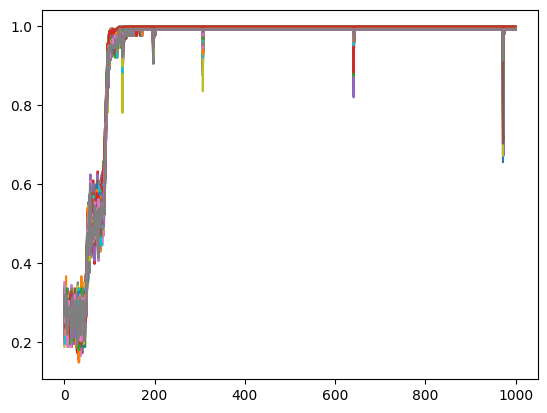

In [12]:
plt.plot(all_accs["Adam"], label="train")
plt.plot(all_test_accs["Adam"], label="test")

In [13]:
trained_model = copy.deepcopy(model.state_dict())

In [14]:
model.load_state_dict(trained_model)

<All keys matched successfully>

In [15]:
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# save model
torch.save(model.state_dict(), save_dir / f"{name}.pt")

with open(save_dir / "losses.pkl", "wb") as f:
    pickle.dump(all_losses, f)
with open(save_dir / "accs.pkl", "wb") as f:
    pickle.dump(all_accs, f)
with open(save_dir / "attns.npy", "wb") as f:
    np.save(f, all_attns["Adam"])

Save animation

/usr/bin/pdflatex


/usr/bin/pdflatex
/usr/bin/pdflatex
/usr/bin/pdflatex


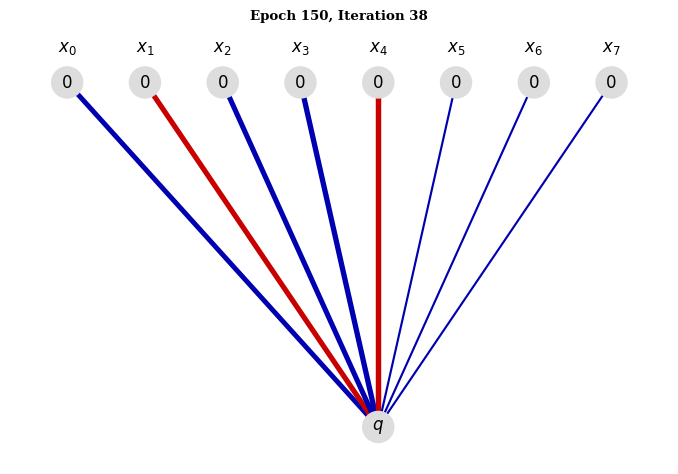

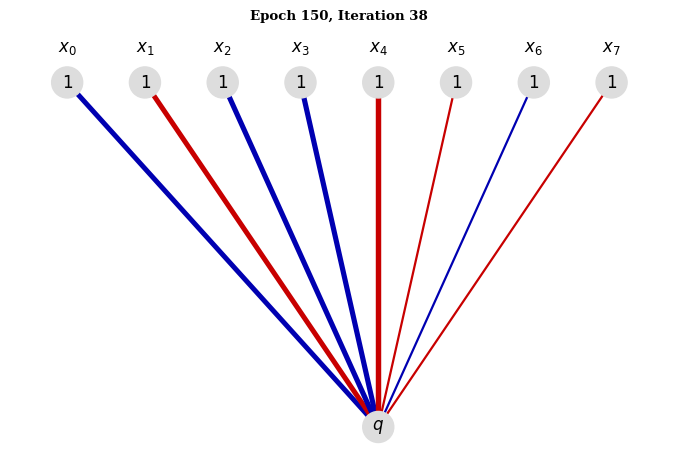

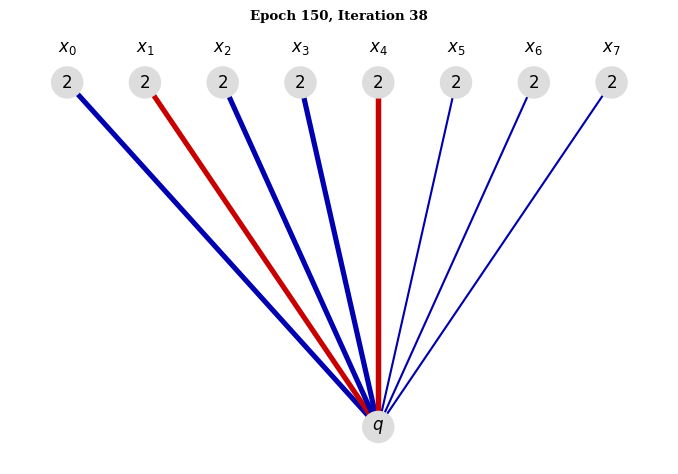

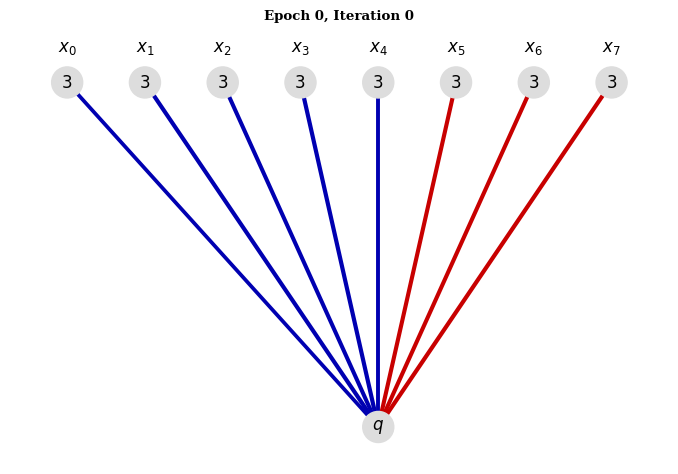

In [ ]:
plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio
for sample in range(vocab_size):

    rc("font", family="serif", size=8)
    usetex = not subprocess.run(["which", "pdflatex"]).returncode
    usetex = False
    rc("text", usetex=usetex)
    if usetex:
        rc("text.latex", preamble=r"\usepackage{times}")

    N = length

    fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
    G, pos = build_1L_graph(N)
    magnifier = 8 / attns.max()
    weights = 0

    color_palette = [
        '#c80000',
        '#0000b1',
    ]


    def update(frame):
        global weights

        # update variables
        ax.clear()
        old_weights = weights
        # weights = attns[10 * frame].mean(axis=0)
        epoch, i = divmod(frame, len(train_loader))
        epoch = 10 * epoch
        weights = attns[epoch, i, sample]
        G, pos = build_1L_graph_tokens(N, tokens=X_test[sample].tolist())
        node_colors = ["#ffffff"]*N + ["#dddddd"]*N + ["#dddddd"]
        T = 0.2
        weights = torch.exp(weights / T)
        weights /= torch.sum(weights)

        # color edges according to updates
        diff = weights - old_weights
        colors = [color_palette[0] if d > 0 else color_palette[1] for d in diff]

        # draw the updated graph
        nx.draw(
            G,
            pos,
            width=magnifier * weights,
            with_labels=True,
            edge_color=colors,
            node_size=500,
            node_color=node_colors,
            labels={rf"$y_{{{i}}}$": j for i, j in enumerate(X_test[sample].tolist())} | {rf"$x_{{{i}}}$": rf"$x_{{{i}}}$" for i in range(N)} | {r"$q$": r"$q$"},
            ax=ax,
        )
        ax.set_title(f"Epoch {epoch}, Iteration {i}", fontweight="bold")


    ani_length = 1000 - 1
    ani = animation.FuncAnimation(fig, update, frames=ani_length, repeat=False)
    # ani.save(save_dir / "test.gif", writer="imagemagick", fps=20)
    ani.save(save_dir / f"test_{sample}.mp4", writer="ffmpeg", fps=20)

Save different frames

In [ ]:
save_dir = Path.home() / "attns_visu.npy"
attns = np.load(save_dir, allow_pickle=True)

In [ ]:
plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio
sample = 3

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

N = length

magnifier = 8 / attns.max()
weights = 0

color_palette = [
    '#c80000',
    '#0000b1',
]


for epoch in [0, 50, 10, 150]:
    for iteration in range(1, 64):
        fig, ax = plt.subplots(figsize=(.3 * WIDTH, .3 * HEIGHT))
        G, pos = build_1L_graph(N)
        G, pos = build_1L_graph_tokens(N, tokens=test_data[sample].tolist())
        node_colors = ["#ffffff"]*N + ["#dddddd"]*N + ["#dddddd"]
        T = 0.05

        old_weights = attns[epoch, iteration - 1, sample]
        old_weights = np.exp(old_weights / T)
        old_weights /= np.sum(old_weights)

        weights = attns[epoch, iteration, sample]
        weights = np.exp(weights / T)
        weights /= np.sum(weights)

        # color edges according to updates
        diff = weights - old_weights
        colors = [color_palette[0] if d > 0 else color_palette[1] for d in diff]

        # draw the updated graph
        nx.draw(
            G,
            pos,
            width=magnifier * weights,
            with_labels=True,
            edge_color=colors,
            node_size=150,
            node_color=node_colors,
            labels={rf"$y_{{{i}}}$": int(j) for i, j in enumerate(test_data[sample].tolist())} | {rf"$x_{{{i}}}$": rf"$x_{{{i}}}$" for i in range(N)} | {r"$z$": r"$z$"},
            ax=ax,
            font_size=8,
        )
        ax.set_title(f"Epoch {epoch}, Iteration {iteration}", fontsize=10)
        fig.savefig(f"{epoch}_{iteration}.pdf", bbox_inches="tight")
